In [117]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random
import operator as op
from functools import reduce
from tqdm import tqdm
import copy
import pickle
from scipy import io
import networkx as nx

In [32]:
import numpy as np

# Specify the file path
file_path = '/Users/asalrangraziasl/Documents/ Projects_Master/ Inference/FCth.txt'

# Load the data into a NumPy array
data = np.loadtxt(file_path)

# Now, 'data' contains your dataset as a NumPy array

In [33]:
data

array([[1.        , 0.29007275, 0.33406276, ..., 0.27619268, 0.38820639,
        0.24870905],
       [0.29007275, 1.        , 0.6728313 , ..., 0.20622525, 0.31493987,
        0.20340271],
       [0.33406276, 0.6728313 , 1.        , ..., 0.18990944, 0.34645661,
        0.17841752],
       ...,
       [0.27619268, 0.20622525, 0.18990944, ..., 1.        , 0.4226791 ,
        0.48421177],
       [0.38820639, 0.31493987, 0.34645661, ..., 0.4226791 , 1.        ,
        0.45591268],
       [0.24870905, 0.20340271, 0.17841752, ..., 0.48421177, 0.45591268,
        1.        ]])

In [34]:
np.min(data)

-0.0011110186433460477

Average connectivity strength: 0.30562303109507366
Maximum connectivity strength: 1.0
Minimum connectivity strength: -0.0011110186433460477


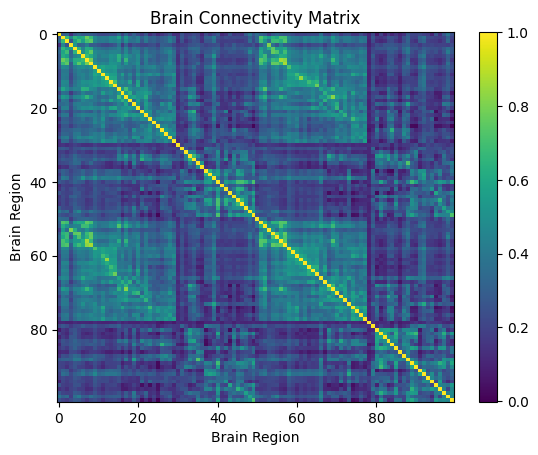

In [35]:
# Example: Calculate the average connectivity strength
average_strength = np.mean(data)
print("Average connectivity strength:", average_strength)

# Example: Calculate the maximum and minimum connectivity strengths
max_strength = np.max(data)
min_strength = np.min(data)
print("Maximum connectivity strength:", max_strength)
print("Minimum connectivity strength:", min_strength)

# Example: Visualize the connectivity matrix (optional)
import matplotlib.pyplot as plt

plt.imshow(data, cmap='viridis', origin='upper', aspect='auto')
plt.colorbar()
plt.title("Brain Connectivity Matrix")
plt.xlabel("Brain Region")
plt.ylabel("Brain Region")
plt.show()

In [36]:
# Set a threshold value (adjust as needed)
threshold = 0.5

# Create a binary connectivity matrix by applying the threshold
A_T = (data > threshold).astype('float64')


In [37]:
A_T

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [38]:
type(A_T)
print(A_T.shape)
print(A_T.dtype)

(100, 100)
float64


### Partitioning

In this part we are partitioning the data then defining some function to use in definition of R and H formula.


In [79]:
#The purpose of this partitioning appears to be part of the Metropolis-Hastings algorithm.
# The binomial coefficien: C(n, r) = n! / (r! * (n - r)!)
def ncr(n, r):  #n choose r
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def index_2d(myList, v): #return the exact index
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))

def l_ij(alpha,beta, A_T,part):       #number of links between group i and j
    link_num = 0
    for a in part[alpha]:
        for b in part[beta]:
            if A_T[a, b] == 1:
                link_num += 1
    return(link_num)


def r_ij(alpha,beta, part):       #maximum possible number of links between group i and j
    return(len(part[alpha]) * len(part[beta]))

In [40]:
# just example of function index_2d
#myList = [
#    [1, 2, 3],
#    [4, 5, 6],
#   [7, 8, 9]
#]

#result = index_2d(myList, 1)
#print(result)  # Output: (1, 1) :5

#### We use the link reliability to identify missing and spurious interactions in network observations
Here we are defining the 3 and 4 formula(R,H)

In [109]:
def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
    big_sum= 0
    Z=0
    first_loop_cond = True
    for part in all_part:

        if first_loop_cond:
            gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]
            pair_list=[]
            for x in gooz_list:
                if x not in pair_list: pair_list.append(x)

            # H(p) formula
            H_P = 0
            for pair in pair_list:
                alpha, beta = pair
                l = l_ij(alpha, beta, A_T, part)
                r = r_ij(alpha, beta, part)
                h_p = math.log(r+1) + math.log(ncr(r, l))
                H_P += h_p

            Z += np.exp(-H_P)
            first_loop_cond = False
        # print('Pair:',pair,',l:',l,',r:',r,',h_p:',h_p,',H_P:',H_P)


        # define : (l(sigma_i,sigma_j) + 1) / (r(sigma_i,sigma_j) + 2) inside R formula
        sigma_i = index_2d(part, i)[0]
        sigma_j = index_2d(part, j)[0]
        l = l_ij(sigma_i , sigma_j , A_T, part)
        r = r_ij(sigma_i , sigma_j , part)
        parantez = ((l + 1)/(r+2))

        # print(Z)
        big_sum += parantez* np.exp(-H_P)
        R_ij = big_sum/Z
        # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
    return(round(R_ij,5))






In [110]:
# I also define H(P) seperatly because I need it in metropolis function
def H(P,A_T_in):
    pair_list=[]
    H_P=0
    for i in range(len(P)):
        for j in range(len(P)):
            if i<=j:
                pair_list.append([i,j])
    for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, A_T_in, P)
            r = r_ij(alpha, beta, P)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
    return(H_P)

### Metropolis algorithm
In practice, it is not possible to sum over all partitions even for
small networks.† However, since Eq. 3 has the same mathematical form as an ensemble average in statistical mechanics (22), one can use the Metropolis algorithm to correctly sample relevant partitions (that is, partitions that significantly contribute to the sum) and obtain estimates for the link reliability
 ### Materials and Methods:
 1. At each step we select a random node and attempt to move it to a ran- domly selected group.
 2. To decide whether we accept the move, we calculate the change ΔH.

In [111]:
def Metro(T,ens,A_T):#number of iterations (ensemble size)
    e=[] #store result of simulation
    for i in tqdm(range(ens)):
        partitions =  [[i] for i in range(4)].copy()
        c=0
        for kk in range(T):
            partitions = [ele for ele in partitions if ele != []]
            part_before=copy.deepcopy(partitions)

            H0=H(partitions,A_T) #compute hamiltonian
            rpp=random.randint(0,len(partitions)-1)
            m,n=index_2d(partitions,rpp)
            a=partitions[m][n] #select random partition from rpp
            del partitions[m][n] #delete an element at a specific position in a 2D list
            rp=random.randint(0,len(partitions)-1)
            partitions[rp].append(a) #moves (a) to another random partition rp
            Hf=H(partitions,A_T)
            deltaH=Hf-H0 #calculates the change in energy due to move
            if deltaH>0:
                if random.random() > np.exp(-deltaH):
                    partitions=part_before.copy()
        ppp = [ele for ele in partitions if ele != []]
        e.append(ppp)
            # partitions=[ele for ele in partitions if ele != []]
            #e.append(ppp)

        # ppp=copy.deepcopy(partitions)
        # e.append(ppp) # The final partitioning is appended to the e list
        print(H(partitions,A_T))
        print(kk)
    return(e)

In [112]:
# We sample the partition space by considering S = 10^4 partitions
# Metro(10000, 10) : NAN = MEAN VALUE
# Metro(10000, 50) : NAN
# Metro(1000, 50) : NAN
# Metro(1000, 200) : NAN
# Metro(2000, 100) : NAN
es = Metro(1000, 20,A_T)

 65%|██████▌   | 13/20 [00:00<00:00, 61.95it/s]

4.828313737302301
999
4.828313737302301
999
4.828313737302301
999
4.828313737302301
999
4.828313737302301
999
4.828313737302301
999
4.828313737302301
999
4.828313737302301
999
4.828313737302301
999
4.828313737302301
999
4.828313737302301
999
12.295867644646389
999
4.828313737302301
999
4.828313737302301
999
4.828313737302301
999
4.828313737302301
999


100%|██████████| 20/20 [00:00<00:00, 63.17it/s]

4.828313737302301
999
12.295867644646389
999
12.295867644646389
999
4.828313737302301
999


In [107]:
es

[[[2, 0], [3, 1]],
 [[2, 0], [3, 1]],
 [[2, 0], [3, 1]],
 [[2, 0], [3, 1]],
 [[3, 1], [2, 0]],
 [[2, 0], [3, 1]],
 [[2, 0], [3, 1]],
 [[2, 0], [3, 1]],
 [[3, 2, 1, 0]],
 [[2, 0], [3, 1]],
 [[2, 0], [3, 1]],
 [[3, 1], [2, 0]],
 [[2, 0], [3, 1]],
 [[2, 0], [3, 1]],
 [[2, 0], [3, 1]],
 [[2, 0], [3, 1]],
 [[2, 0], [3, 1]],
 [[2, 0], [3, 1]],
 [[2, 0], [3, 1]],
 [[2, 0], [3, 1]]]

In [55]:

for rand_num in range(25):
    es_tmp = Metro(10000, 20,A_T)
    with open('esFile/es'+str(rand_num)+'.pkl', 'wb') as file:
        pickle.dump(es_tmp, file)
    print('-------------------------------------')
    print('Number of metro and simulation:',rand_num)
    zero_real = []
    zero_index = np.where(A_T==0)
    for i in tqdm(range(len(zero_index[0]))):
        zero_real.append(R(zero_index[0][i], zero_index[1][i], A_T, es_tmp))

  5%|▌         | 1/20 [00:32<10:21, 32.71s/it]

1866.0235026684206
9999


 10%|█         | 2/20 [01:04<09:39, 32.17s/it]

1829.9307497717566
9999


 15%|█▌        | 3/20 [01:36<09:07, 32.19s/it]

1872.4820442715811
9999


 20%|██        | 4/20 [02:08<08:35, 32.22s/it]

1807.4899696138837
9999


 25%|██▌       | 5/20 [02:43<08:17, 33.14s/it]

1893.476176158564
9999


 30%|███       | 6/20 [03:20<07:59, 34.24s/it]

1856.9958903155384
9999


 35%|███▌      | 7/20 [03:53<07:19, 33.83s/it]

1845.6956963089574
9999


 40%|████      | 8/20 [04:26<06:42, 33.58s/it]

1869.5402086623133
9999


 45%|████▌     | 9/20 [05:00<06:10, 33.68s/it]

1850.499443737039
9999


 50%|█████     | 10/20 [05:32<05:31, 33.19s/it]

1869.8202782346498
9999


 55%|█████▌    | 11/20 [06:03<04:53, 32.66s/it]

1876.7852050678139
9999


 60%|██████    | 12/20 [06:36<04:22, 32.78s/it]

1927.0364532380686
9999


 65%|██████▌   | 13/20 [07:10<03:51, 33.11s/it]

1903.110487895862
9999


 70%|███████   | 14/20 [07:40<03:13, 32.28s/it]

1841.7766116518703
9999


 75%|███████▌  | 15/20 [08:14<02:43, 32.73s/it]

1873.4225107681377
9999


 80%|████████  | 16/20 [08:49<02:12, 33.22s/it]

1848.0482099994
9999


 85%|████████▌ | 17/20 [09:24<01:41, 33.90s/it]

1861.449129221893
9999


 90%|█████████ | 18/20 [09:58<01:07, 33.98s/it]

1914.5682910492817
9999


 95%|█████████▌| 19/20 [10:33<00:34, 34.11s/it]

1879.6559609006808
9999


100%|██████████| 20/20 [11:06<00:00, 33.34s/it]


1911.7891803251791
9999
-------------------------------------
Number of metro and simulation: 0


  0%|          | 0/9122 [00:00<?, ?it/s]/var/folders/jw/91h5jhw96l52xy2j8gdkkz7r0000gn/T/ipykernel_1532/768639317.py:36: RuntimeWarning: invalid value encountered in scalar divide
  R_ij = big_sum/Z
  5%|▌         | 1/20 [00:34<10:59, 34.71s/it]

1838.5461573118223
9999


 10%|█         | 2/20 [01:06<09:49, 32.75s/it]

1895.5647419502304
9999


 15%|█▌        | 3/20 [01:37<09:07, 32.23s/it]

1870.949234684597
9999


 20%|██        | 4/20 [02:12<08:53, 33.35s/it]

1850.0879585747466
9999


 25%|██▌       | 5/20 [02:47<08:27, 33.80s/it]

1855.2128274269164
9999


 30%|███       | 6/20 [03:18<07:42, 33.00s/it]

1883.5650411190175
9999


 35%|███▌      | 7/20 [03:51<07:09, 33.02s/it]

1868.13746754622
9999


 40%|████      | 8/20 [04:26<06:43, 33.61s/it]

1919.0850694121807
9999


 45%|████▌     | 9/20 [05:04<06:22, 34.78s/it]

1847.1567069600762
9999


 50%|█████     | 10/20 [05:37<05:44, 34.47s/it]

1868.60176305689
9999


 55%|█████▌    | 11/20 [06:12<05:10, 34.52s/it]

1860.7736688590662
9999


 60%|██████    | 12/20 [06:42<04:26, 33.28s/it]

1860.5579159328568
9999


 65%|██████▌   | 13/20 [07:15<03:50, 32.91s/it]

1879.6576220091235
9999


 70%|███████   | 14/20 [07:45<03:13, 32.21s/it]

1870.1642873416602
9999


 75%|███████▌  | 15/20 [08:17<02:39, 31.98s/it]

1900.7572020062378
9999


 80%|████████  | 16/20 [08:50<02:09, 32.28s/it]

1961.754510228721
9999


 85%|████████▌ | 17/20 [09:24<01:38, 32.98s/it]

1920.9288175612628
9999


 90%|█████████ | 18/20 [09:59<01:07, 33.66s/it]

1845.0958101464778
9999


 95%|█████████▌| 19/20 [10:33<00:33, 33.73s/it]

1845.6928669348188
9999


100%|██████████| 20/20 [11:06<00:00, 33.33s/it]


1876.3292039396626
9999
-------------------------------------
Number of metro and simulation: 1


  5%|▌         | 1/20 [00:32<10:11, 32.18s/it]

1848.0846781126443
9999


 10%|█         | 2/20 [01:07<10:10, 33.90s/it]

1888.796570391812
9999


 15%|█▌        | 3/20 [01:43<09:55, 35.04s/it]

1881.126515308027
9999


 20%|██        | 4/20 [02:17<09:14, 34.66s/it]

1925.3480578943286
9999


 25%|██▌       | 5/20 [02:51<08:34, 34.32s/it]

1868.4759146571873
9999


 30%|███       | 6/20 [03:28<08:11, 35.14s/it]

1909.8330027642373
9999


 35%|███▌      | 7/20 [04:02<07:32, 34.82s/it]

1869.836090270892
9999


 40%|████      | 8/20 [04:35<06:50, 34.19s/it]

1844.360996622755
9999


 45%|████▌     | 9/20 [05:05<06:02, 32.96s/it]

1827.415964488299
9999


 50%|█████     | 10/20 [05:37<05:25, 32.53s/it]

1849.6207881222615
9999


 55%|█████▌    | 11/20 [06:12<04:59, 33.32s/it]

1884.7894693610324
9999


 60%|██████    | 12/20 [06:45<04:26, 33.36s/it]

1882.7005062036844
9999


 65%|██████▌   | 13/20 [07:18<03:52, 33.23s/it]

1878.9092964623626
9999


 70%|███████   | 14/20 [07:52<03:21, 33.61s/it]

1818.0519604110555
9999


 75%|███████▌  | 15/20 [08:26<02:47, 33.44s/it]

1928.1148255745961
9999


 80%|████████  | 16/20 [08:57<02:11, 32.80s/it]

1829.9003917014536
9999


 85%|████████▌ | 17/20 [09:31<01:40, 33.35s/it]

1867.3587287782823
9999


 90%|█████████ | 18/20 [10:05<01:07, 33.53s/it]

1803.6027975726288
9999


 95%|█████████▌| 19/20 [10:38<00:33, 33.14s/it]

1887.4576874793643
9999


100%|██████████| 20/20 [11:12<00:00, 33.61s/it]


1888.3643380420447
9999
-------------------------------------
Number of metro and simulation: 2


  5%|▌         | 1/20 [00:32<10:12, 32.22s/it]

1855.9928849140024
9999


 10%|█         | 2/20 [01:04<09:38, 32.16s/it]

1840.9277881346522
9999


 15%|█▌        | 3/20 [01:37<09:11, 32.47s/it]

1902.1301746261393
9999


 20%|██        | 4/20 [02:11<08:48, 33.01s/it]

1869.4140565278828
9999


 25%|██▌       | 5/20 [02:42<08:05, 32.38s/it]

1825.3628661693806
9999


 30%|███       | 6/20 [03:15<07:35, 32.53s/it]

1766.7806290340334
9999


 35%|███▌      | 7/20 [03:48<07:07, 32.92s/it]

1865.3600857728604
9999


 40%|████      | 8/20 [04:23<06:42, 33.52s/it]

1927.6950141403447
9999


 45%|████▌     | 9/20 [04:55<06:04, 33.11s/it]

1807.2428789077424
9999


 50%|█████     | 10/20 [05:30<05:35, 33.55s/it]

1908.1287971966992
9999


 55%|█████▌    | 11/20 [06:04<05:04, 33.87s/it]

1911.4048749264482
9999


 60%|██████    | 12/20 [06:39<04:32, 34.02s/it]

1912.0464633645247
9999


 65%|██████▌   | 13/20 [07:10<03:51, 33.04s/it]

1848.1016510779486
9999


 70%|███████   | 14/20 [07:43<03:19, 33.29s/it]

1874.5214743943643
9999


 75%|███████▌  | 15/20 [08:15<02:43, 32.66s/it]

1869.6987493616596
9999


 80%|████████  | 16/20 [08:50<02:13, 33.32s/it]

1866.400740636957
9999


 85%|████████▌ | 17/20 [09:20<01:37, 32.49s/it]

1825.3341583270633
9999


 90%|█████████ | 18/20 [09:54<01:05, 32.90s/it]

1860.8343662646994
9999


 95%|█████████▌| 19/20 [10:26<00:32, 32.71s/it]

1797.0770202982437
9999


100%|██████████| 20/20 [10:58<00:00, 32.91s/it]


1861.7278982131165
9999
-------------------------------------
Number of metro and simulation: 3


  5%|▌         | 1/20 [00:33<10:44, 33.91s/it]

1875.2118357988506
9999


 10%|█         | 2/20 [01:06<10:01, 33.42s/it]

1852.69771003115
9999


 15%|█▌        | 3/20 [01:41<09:37, 33.98s/it]

1890.5856460466284
9999


 20%|██        | 4/20 [02:14<08:56, 33.56s/it]

1883.8947212226449
9999


 25%|██▌       | 5/20 [02:48<08:26, 33.77s/it]

1838.3409051892963
9999


 30%|███       | 6/20 [03:21<07:46, 33.31s/it]

1886.7242677420682
9999


 35%|███▌      | 7/20 [03:51<07:01, 32.42s/it]

1816.6337911297196
9999


 40%|████      | 8/20 [04:23<06:27, 32.32s/it]

1824.2377444993708
9999


 45%|████▌     | 9/20 [04:59<06:06, 33.30s/it]

1874.0281596976715
9999


 50%|█████     | 10/20 [05:32<05:32, 33.22s/it]

1865.0970266273912
9999


 55%|█████▌    | 11/20 [06:06<05:02, 33.63s/it]

1921.6501364273463
9999


 60%|██████    | 12/20 [06:40<04:29, 33.68s/it]

1895.6707772871237
9999


 65%|██████▌   | 13/20 [07:13<03:54, 33.46s/it]

1868.8999570621284
9999


 70%|███████   | 14/20 [07:46<03:20, 33.41s/it]

1854.1866272157517
9999


 75%|███████▌  | 15/20 [08:17<02:42, 32.54s/it]

1878.8896420892497
9999


 80%|████████  | 16/20 [08:49<02:09, 32.27s/it]

1790.9735722690182
9999


 85%|████████▌ | 17/20 [09:24<01:39, 33.23s/it]

1879.0446984909292
9999


 90%|█████████ | 18/20 [09:57<01:06, 33.19s/it]

1898.5956679886424
9999


 95%|█████████▌| 19/20 [10:30<00:33, 33.11s/it]

1835.520836845268
9999


100%|██████████| 20/20 [11:04<00:00, 33.22s/it]


1877.1521061787987
9999
-------------------------------------
Number of metro and simulation: 4


  5%|▌         | 1/20 [00:30<09:36, 30.33s/it]

1902.7695032830518
9999


 10%|█         | 2/20 [01:06<10:03, 33.51s/it]

1901.9600216975323
9999


 15%|█▌        | 3/20 [01:39<09:27, 33.41s/it]

1892.2401551732237
9999


 20%|██        | 4/20 [02:13<09:01, 33.86s/it]

1931.8560679387924
9999


 25%|██▌       | 5/20 [02:47<08:28, 33.91s/it]

1870.9610914951886
9999


 30%|███       | 6/20 [03:21<07:54, 33.87s/it]

1864.445111669635
9999


 35%|███▌      | 7/20 [03:56<07:25, 34.23s/it]

1920.7219257250722
9999


 40%|████      | 8/20 [04:30<06:50, 34.19s/it]

1874.886408516261
9999


 45%|████▌     | 9/20 [05:06<06:22, 34.80s/it]

1873.8313707880093
9999


 50%|█████     | 10/20 [05:39<05:42, 34.24s/it]

1892.6240618401098
9999


 55%|█████▌    | 11/20 [06:13<05:05, 33.94s/it]

1835.5073701856966
9999


 60%|██████    | 12/20 [06:46<04:28, 33.61s/it]

1858.2515912066701
9999


 65%|██████▌   | 13/20 [07:14<03:43, 31.94s/it]

1854.57366110782
9999


 70%|███████   | 14/20 [07:46<03:12, 32.10s/it]

1847.653206575968
9999


 75%|███████▌  | 15/20 [08:18<02:39, 31.94s/it]

1859.7596581473579
9999


 80%|████████  | 16/20 [08:52<02:10, 32.54s/it]

1897.8042666110264
9999


 85%|████████▌ | 17/20 [09:25<01:38, 32.74s/it]

1899.947530970541
9999


 90%|█████████ | 18/20 [10:00<01:06, 33.43s/it]

1881.1067355183663
9999


 95%|█████████▌| 19/20 [10:30<00:32, 32.55s/it]

1815.349794976906
9999


100%|██████████| 20/20 [11:03<00:00, 33.20s/it]


1913.8801284242336
9999
-------------------------------------
Number of metro and simulation: 5


  5%|▌         | 1/20 [00:35<11:06, 35.06s/it]

1949.5619939697299
9999


 10%|█         | 2/20 [01:09<10:23, 34.66s/it]

1886.1881134761677
9999


 15%|█▌        | 3/20 [01:43<09:44, 34.41s/it]

1844.749023672158
9999


 20%|██        | 4/20 [02:17<09:06, 34.16s/it]

1870.8263587212791
9999


 25%|██▌       | 5/20 [02:50<08:26, 33.75s/it]

1887.1926665301705
9999


 30%|███       | 6/20 [03:22<07:45, 33.26s/it]

1842.9101892650494
9999


 35%|███▌      | 7/20 [03:58<07:22, 34.04s/it]

1893.5044155735434
9999


 40%|████      | 8/20 [04:27<06:30, 32.54s/it]

1866.4534309818673
9999


 45%|████▌     | 9/20 [04:59<05:54, 32.21s/it]

1880.4917627904665
9999


 50%|█████     | 10/20 [05:33<05:27, 32.78s/it]

1852.1949023561046
9999


 55%|█████▌    | 11/20 [06:05<04:53, 32.58s/it]

1919.223619622697
9999


 60%|██████    | 12/20 [06:37<04:18, 32.33s/it]

1829.0356217054325
9999


 65%|██████▌   | 13/20 [07:10<03:48, 32.64s/it]

1808.195361522247
9999


 70%|███████   | 14/20 [07:43<03:17, 32.87s/it]

1893.4792367809464
9999


 75%|███████▌  | 15/20 [08:16<02:44, 32.87s/it]

1888.8538728727253
9999


 80%|████████  | 16/20 [08:49<02:11, 32.89s/it]

1848.779270629288
9999


 85%|████████▌ | 17/20 [09:20<01:37, 32.44s/it]

1877.9245077294463
9999


 90%|█████████ | 18/20 [09:54<01:05, 32.82s/it]

1800.411243632377
9999


 95%|█████████▌| 19/20 [10:29<00:33, 33.49s/it]

1831.1947768856912
9999


100%|██████████| 20/20 [11:01<00:00, 33.06s/it]


1824.384403069232
9999
-------------------------------------
Number of metro and simulation: 6


  5%|▌         | 1/20 [00:34<10:51, 34.28s/it]

1863.9607254350171
9999


 10%|█         | 2/20 [01:08<10:13, 34.09s/it]

1898.4063040971291
9999


 15%|█▌        | 3/20 [01:39<09:19, 32.88s/it]

1861.5523242794561
9999


 20%|██        | 4/20 [02:14<08:55, 33.48s/it]

1854.8256571025172
9999


 25%|██▌       | 5/20 [02:47<08:20, 33.40s/it]

1894.908416125263
9999


 30%|███       | 6/20 [03:21<07:51, 33.68s/it]

1856.6002965505454
9999


 35%|███▌      | 7/20 [03:52<07:08, 32.94s/it]

1880.362073500638
9999


 40%|████      | 8/20 [04:25<06:33, 32.81s/it]

1901.776521710641
9999


 45%|████▌     | 9/20 [05:00<06:07, 33.41s/it]

1922.7128184934077
9999


 50%|█████     | 10/20 [05:31<05:28, 32.82s/it]

1865.1997943420247
9999


 55%|█████▌    | 11/20 [06:04<04:54, 32.70s/it]

1846.9728057204443
9999


 60%|██████    | 12/20 [06:38<04:26, 33.35s/it]

1870.9410445142357
9999


 65%|██████▌   | 13/20 [07:11<03:51, 33.03s/it]

1835.8742120997308
9999


 70%|███████   | 14/20 [07:43<03:16, 32.83s/it]

1856.9865282320613
9999


 75%|███████▌  | 15/20 [08:15<02:43, 32.63s/it]

1809.3809554431632
9999


 80%|████████  | 16/20 [08:48<02:10, 32.72s/it]

1836.3038035533486
9999


 85%|████████▌ | 17/20 [09:22<01:39, 33.06s/it]

1871.3986687587396
9999


 90%|█████████ | 18/20 [09:56<01:06, 33.34s/it]

1890.5445826616733
9999


 95%|█████████▌| 19/20 [10:29<00:33, 33.36s/it]

1886.5031294524244
9999


100%|██████████| 20/20 [11:03<00:00, 33.16s/it]


1868.149177437614
9999
-------------------------------------
Number of metro and simulation: 7


  5%|▌         | 1/20 [00:32<10:26, 32.97s/it]

1871.6262457264763
9999


 10%|█         | 2/20 [01:03<09:31, 31.73s/it]

1809.7775207071102
9999


 15%|█▌        | 3/20 [01:39<09:31, 33.61s/it]

1848.9599233071729
9999


 20%|██        | 4/20 [02:14<09:03, 33.96s/it]

1888.818243915612
9999


 25%|██▌       | 5/20 [02:49<08:38, 34.58s/it]

1933.4842263850956
9999


 30%|███       | 6/20 [03:24<08:04, 34.64s/it]

1813.1643377629557
9999


 35%|███▌      | 7/20 [03:57<07:21, 33.95s/it]

1868.63702474577
9999


 40%|████      | 8/20 [04:32<06:54, 34.55s/it]

1923.9177485581206
9999


 45%|████▌     | 9/20 [05:05<06:12, 33.86s/it]

1849.2301404331154
9999


 50%|█████     | 10/20 [05:38<05:36, 33.60s/it]

1902.9890412821455
9999


 55%|█████▌    | 11/20 [06:11<05:01, 33.46s/it]

1803.722271106988
9999


 60%|██████    | 12/20 [06:47<04:33, 34.14s/it]

1871.411684977371
9999


 65%|██████▌   | 13/20 [07:19<03:54, 33.55s/it]

1844.8997045770714
9999


 70%|███████   | 14/20 [07:53<03:22, 33.67s/it]

1868.8616460572027
9999


 75%|███████▌  | 15/20 [08:26<02:47, 33.44s/it]

1830.155218212557
9999


 80%|████████  | 16/20 [09:00<02:14, 33.56s/it]

1854.2347812842386
9999


 85%|████████▌ | 17/20 [09:32<01:39, 33.33s/it]

1858.5042229060484
9999


 90%|█████████ | 18/20 [10:04<01:05, 32.94s/it]

1929.4519733615734
9999


 95%|█████████▌| 19/20 [10:38<00:33, 33.16s/it]

1880.8888767029805
9999


100%|██████████| 20/20 [11:11<00:00, 33.59s/it]


1915.1628008802659
9999
-------------------------------------
Number of metro and simulation: 8


  5%|▌         | 1/20 [00:31<09:56, 31.40s/it]

1850.257657130841
9999


 10%|█         | 2/20 [01:03<09:31, 31.74s/it]

1824.8134540999622
9999


 15%|█▌        | 3/20 [01:33<08:50, 31.23s/it]

1820.6427638654206
9999


 20%|██        | 4/20 [02:06<08:25, 31.57s/it]

1855.0149755056066
9999


 25%|██▌       | 5/20 [02:39<08:02, 32.16s/it]

1868.8114646785054
9999


 30%|███       | 6/20 [03:11<07:31, 32.21s/it]

1819.621486234255
9999


 35%|███▌      | 7/20 [03:47<07:12, 33.25s/it]

1854.0094511462216
9999


 40%|████      | 8/20 [04:20<06:41, 33.47s/it]

1861.1683086315443
9999


 45%|████▌     | 9/20 [04:54<06:09, 33.61s/it]

1834.8193926956885
9999


 50%|█████     | 10/20 [05:28<05:36, 33.68s/it]

1866.2312794618474
9999


 55%|█████▌    | 11/20 [06:00<04:57, 33.02s/it]

1871.5946956809707
9999


 60%|██████    | 12/20 [06:34<04:26, 33.31s/it]

1899.3232561808359
9999


 65%|██████▌   | 13/20 [07:05<03:49, 32.75s/it]

1827.929175504921
9999


 70%|███████   | 14/20 [07:39<03:19, 33.17s/it]

1874.8171932187465
9999


 75%|███████▌  | 15/20 [08:13<02:47, 33.43s/it]

1869.4888205421967
9999


 80%|████████  | 16/20 [08:47<02:14, 33.57s/it]

1890.1997480418008
9999


 85%|████████▌ | 17/20 [09:19<01:38, 32.95s/it]

1904.0101527289414
9999


 90%|█████████ | 18/20 [09:52<01:06, 33.05s/it]

1931.7819406284216
9999


 95%|█████████▌| 19/20 [10:24<00:32, 32.86s/it]

1871.3313548500275
9999


100%|██████████| 20/20 [10:59<00:00, 32.99s/it]


1883.2811448861705
9999
-------------------------------------
Number of metro and simulation: 9


  5%|▌         | 1/20 [00:31<09:53, 31.26s/it]

1884.1008633829892
9999


 10%|█         | 2/20 [01:00<09:03, 30.20s/it]

1878.7555874997465
9999


 15%|█▌        | 3/20 [01:34<09:01, 31.87s/it]

1815.928107185394
9999


 20%|██        | 4/20 [02:10<08:54, 33.39s/it]

1919.9475883903285
9999


 25%|██▌       | 5/20 [02:44<08:27, 33.81s/it]

1891.6275408111892
9999


 30%|███       | 6/20 [03:19<07:57, 34.09s/it]

1836.486819026163
9999


 35%|███▌      | 7/20 [03:53<07:22, 34.02s/it]

1883.3167685516107
9999


 40%|████      | 8/20 [04:26<06:44, 33.75s/it]

1905.9778032610152
9999


 45%|████▌     | 9/20 [04:59<06:07, 33.45s/it]

1941.2432841287664
9999


 50%|█████     | 10/20 [05:34<05:39, 33.94s/it]

1907.2554811601283
9999


 55%|█████▌    | 11/20 [06:08<05:05, 33.96s/it]

1900.2375248339629
9999


 60%|██████    | 12/20 [06:40<04:27, 33.41s/it]

1861.3942895881646
9999


 65%|██████▌   | 13/20 [07:13<03:53, 33.37s/it]

1790.944071853991
9999


 70%|███████   | 14/20 [07:48<03:23, 33.87s/it]

1908.7923074795722
9999


 75%|███████▌  | 15/20 [08:22<02:48, 33.70s/it]

1829.2095291121207
9999


 80%|████████  | 16/20 [08:54<02:12, 33.21s/it]

1890.2508331773504
9999


 85%|████████▌ | 17/20 [09:29<01:41, 33.74s/it]

1954.3993148790894
9999


 90%|█████████ | 18/20 [10:04<01:08, 34.12s/it]

1889.9702191645417
9999


 95%|█████████▌| 19/20 [10:36<00:33, 33.57s/it]

1901.9406253744237
9999


100%|██████████| 20/20 [11:09<00:00, 33.49s/it]


1816.417132552268
9999
-------------------------------------
Number of metro and simulation: 10


  5%|▌         | 1/20 [00:33<10:27, 33.04s/it]

1868.6137124437168
9999


 10%|█         | 2/20 [01:05<09:48, 32.72s/it]

1919.7942080219843
9999


 15%|█▌        | 3/20 [01:36<09:02, 31.89s/it]

1914.0969785654665
9999


 20%|██        | 4/20 [02:09<08:36, 32.29s/it]

1882.044629233094
9999


 25%|██▌       | 5/20 [02:43<08:12, 32.83s/it]

1817.8982880546237
9999


 30%|███       | 6/20 [03:17<07:45, 33.27s/it]

1817.8284341153624
9999


 35%|███▌      | 7/20 [03:50<07:11, 33.19s/it]

1836.1967825778568
9999


 40%|████      | 8/20 [04:23<06:39, 33.28s/it]

1897.6485520189938
9999


 45%|████▌     | 9/20 [04:58<06:11, 33.81s/it]

1893.0636963515542
9999


 50%|█████     | 10/20 [05:31<05:35, 33.59s/it]

1905.9577425248467
9999


 55%|█████▌    | 11/20 [06:06<05:03, 33.78s/it]

1838.6387482248808
9999


 60%|██████    | 12/20 [06:39<04:30, 33.79s/it]

1869.880043048341
9999


 65%|██████▌   | 13/20 [07:16<04:01, 34.51s/it]

1885.1430685212144
9999


 70%|███████   | 14/20 [07:50<03:26, 34.40s/it]

1898.8246614609552
9999


 75%|███████▌  | 15/20 [08:21<02:47, 33.42s/it]

1763.0412290413424
9999


 80%|████████  | 16/20 [08:53<02:12, 33.01s/it]

1835.422869788647
9999


 85%|████████▌ | 17/20 [09:25<01:38, 32.71s/it]

1870.2814571405213
9999


 90%|█████████ | 18/20 [09:56<01:04, 32.19s/it]

1897.3192513426584
9999


 95%|█████████▌| 19/20 [10:31<00:33, 33.22s/it]

1884.7856518783778
9999


100%|██████████| 20/20 [11:04<00:00, 33.22s/it]


1871.8884981411713
9999
-------------------------------------
Number of metro and simulation: 11


  5%|▌         | 1/20 [00:33<10:30, 33.18s/it]

1891.4140454514725
9999


 10%|█         | 2/20 [01:05<09:53, 32.96s/it]

1869.4617420637264
9999


 15%|█▌        | 3/20 [01:39<09:22, 33.11s/it]

1886.2144422030376
9999


 20%|██        | 4/20 [02:15<09:11, 34.50s/it]

1889.2313684308208
9999


 25%|██▌       | 5/20 [02:49<08:34, 34.33s/it]

1905.988062817093
9999


 30%|███       | 6/20 [03:21<07:47, 33.40s/it]

1945.9072572657035
9999


 35%|███▌      | 7/20 [03:52<07:05, 32.73s/it]

1881.8278195007792
9999


 40%|████      | 8/20 [04:27<06:39, 33.33s/it]

1879.205893765104
9999


 45%|████▌     | 9/20 [05:00<06:05, 33.21s/it]

1900.5253552852685
9999


 50%|█████     | 10/20 [05:33<05:31, 33.19s/it]

1829.171143055233
9999


 55%|█████▌    | 11/20 [06:04<04:52, 32.45s/it]

1877.7002801803797
9999


 60%|██████    | 12/20 [06:38<04:22, 32.86s/it]

1852.012648469606
9999


 65%|██████▌   | 13/20 [07:09<03:47, 32.43s/it]

1935.6684533552348
9999


 70%|███████   | 14/20 [07:41<03:14, 32.35s/it]

1857.6284447177968
9999


 75%|███████▌  | 15/20 [08:15<02:43, 32.72s/it]

1835.9070150176258
9999


 80%|████████  | 16/20 [08:46<02:09, 32.33s/it]

1879.9485846078144
9999


 85%|████████▌ | 17/20 [09:19<01:37, 32.56s/it]

1899.0632979605073
9999


 90%|█████████ | 18/20 [09:53<01:05, 32.96s/it]

1865.352115441546
9999


 95%|█████████▌| 19/20 [10:29<00:33, 33.89s/it]

1856.7131235701734
9999


100%|██████████| 20/20 [11:02<00:00, 33.15s/it]


1869.8766083627193
9999
-------------------------------------
Number of metro and simulation: 12


  5%|▌         | 1/20 [00:32<10:13, 32.30s/it]

1825.8666902362377
9999


 10%|█         | 2/20 [01:06<09:59, 33.32s/it]

1874.3070288754375
9999


 15%|█▌        | 3/20 [01:38<09:21, 33.02s/it]

1834.4105562347702
9999


 20%|██        | 4/20 [02:12<08:48, 33.02s/it]

1832.6982723582566
9999


 25%|██▌       | 5/20 [02:47<08:26, 33.74s/it]

1893.3039482956942
9999


 30%|███       | 6/20 [03:20<07:49, 33.56s/it]

1856.3270849785047
9999


 35%|███▌      | 7/20 [03:53<07:16, 33.60s/it]

1852.189047978065
9999


 40%|████      | 8/20 [04:24<06:31, 32.65s/it]

1835.4842751433662
9999


 45%|████▌     | 9/20 [04:59<06:08, 33.52s/it]

1913.1548908491616
9999


 50%|█████     | 10/20 [05:33<05:36, 33.63s/it]

1896.8856653970652
9999


 55%|█████▌    | 11/20 [06:05<04:56, 32.96s/it]

1861.9161956001856
9999


 60%|██████    | 12/20 [06:38<04:25, 33.14s/it]

1857.9194149617904
9999


 65%|██████▌   | 13/20 [07:12<03:52, 33.19s/it]

1955.4805125229257
9999


 70%|███████   | 14/20 [07:45<03:18, 33.14s/it]

1875.433097850736
9999


 75%|███████▌  | 15/20 [08:20<02:48, 33.70s/it]

1836.5326996550318
9999


 80%|████████  | 16/20 [08:53<02:14, 33.56s/it]

1851.6153170609766
9999


 85%|████████▌ | 17/20 [09:24<01:38, 32.71s/it]

1879.1573071977862
9999


 90%|█████████ | 18/20 [09:57<01:05, 32.88s/it]

1874.4744966946876
9999


 95%|█████████▌| 19/20 [10:30<00:32, 32.93s/it]

1834.189784116699
9999


100%|██████████| 20/20 [11:03<00:00, 33.15s/it]


1871.284577319566
9999
-------------------------------------
Number of metro and simulation: 13


  5%|▌         | 1/20 [00:33<10:44, 33.91s/it]

1844.6809941051276
9999


 10%|█         | 2/20 [01:07<10:03, 33.52s/it]

1900.0353655599586
9999


 15%|█▌        | 3/20 [01:40<09:27, 33.40s/it]

1903.0191254688782
9999


 20%|██        | 4/20 [02:17<09:16, 34.79s/it]

1929.1199183358956
9999


 25%|██▌       | 5/20 [02:50<08:32, 34.20s/it]

1905.2885841429377
9999


 30%|███       | 6/20 [03:22<07:49, 33.53s/it]

1867.2174668941657
9999


 35%|███▌      | 7/20 [03:55<07:13, 33.38s/it]

1876.3623197264114
9999


 40%|████      | 8/20 [04:29<06:40, 33.34s/it]

1936.18276479033
9999


 45%|████▌     | 9/20 [05:02<06:06, 33.33s/it]

1831.4400683490605
9999


 50%|█████     | 10/20 [05:36<05:35, 33.56s/it]

1886.1770951438855
9999


 55%|█████▌    | 11/20 [06:07<04:55, 32.85s/it]

1778.7732896415691
9999


 60%|██████    | 12/20 [06:42<04:27, 33.46s/it]

1919.888195774264
9999


 65%|██████▌   | 13/20 [07:17<03:56, 33.82s/it]

1922.4484660958256
9999


 70%|███████   | 14/20 [07:50<03:21, 33.61s/it]

1845.470970556989
9999


 75%|███████▌  | 15/20 [08:23<02:47, 33.47s/it]

1857.2667623735317
9999


 80%|████████  | 16/20 [08:56<02:13, 33.39s/it]

1881.6900247176047
9999


 85%|████████▌ | 17/20 [09:29<01:40, 33.36s/it]

1852.6778848354809
9999


 90%|█████████ | 18/20 [10:03<01:06, 33.49s/it]

1888.7798409414918
9999


 95%|█████████▌| 19/20 [10:39<00:34, 34.12s/it]

1922.174536485381
9999


100%|██████████| 20/20 [11:13<00:00, 33.66s/it]


1888.221936046245
9999
-------------------------------------
Number of metro and simulation: 14


  5%|▌         | 1/20 [00:31<10:05, 31.89s/it]

1862.7774891729487
9999


 10%|█         | 2/20 [01:06<10:04, 33.57s/it]

1870.64743083015
9999


 15%|█▌        | 3/20 [01:41<09:41, 34.19s/it]

1868.9047409360646
9999


 20%|██        | 4/20 [02:13<08:55, 33.47s/it]

1901.528285791286
9999


 25%|██▌       | 5/20 [02:46<08:19, 33.30s/it]

1865.5724483791666
9999


 30%|███       | 6/20 [03:22<07:58, 34.21s/it]

1907.278863074219
9999


 35%|███▌      | 7/20 [03:54<07:14, 33.39s/it]

1876.8376871011149
9999


 40%|████      | 8/20 [04:28<06:42, 33.57s/it]

1846.7978904056213
9999


 45%|████▌     | 9/20 [05:00<06:02, 32.94s/it]

1841.2554382961423
9999


 50%|█████     | 10/20 [05:32<05:27, 32.71s/it]

1831.2976111883222
9999


 55%|█████▌    | 11/20 [06:05<04:55, 32.87s/it]

1848.3532443374636
9999


 60%|██████    | 12/20 [06:38<04:22, 32.78s/it]

1893.016381256673
9999


 65%|██████▌   | 13/20 [07:07<03:42, 31.75s/it]

1879.4615529952357
9999


 70%|███████   | 14/20 [07:44<03:19, 33.27s/it]

1902.8308736778658
9999


 75%|███████▌  | 15/20 [08:16<02:44, 32.97s/it]

1877.959646079775
9999


 80%|████████  | 16/20 [08:51<02:14, 33.60s/it]

1874.3886888436268
9999


 85%|████████▌ | 17/20 [09:25<01:40, 33.66s/it]

1877.3552457381227
9999


 90%|█████████ | 18/20 [09:59<01:07, 33.74s/it]

1851.3307589688252
9999


 95%|█████████▌| 19/20 [10:32<00:33, 33.58s/it]

1915.6383402434128
9999


100%|██████████| 20/20 [11:05<00:00, 33.29s/it]


1896.5213290938964
9999
-------------------------------------
Number of metro and simulation: 15


  5%|▌         | 1/20 [00:34<10:46, 34.04s/it]

1896.2535796761997
9999


 10%|█         | 2/20 [01:06<09:54, 33.03s/it]

1806.9994698258965
9999


 15%|█▌        | 3/20 [01:38<09:14, 32.64s/it]

1871.5167808118676
9999


 20%|██        | 4/20 [02:11<08:45, 32.84s/it]

1810.9597366466821
9999


 25%|██▌       | 5/20 [02:43<08:08, 32.57s/it]

1842.0647632091755
9999


 30%|███       | 6/20 [03:17<07:41, 32.95s/it]

1913.647486338329
9999


 35%|███▌      | 7/20 [03:53<07:23, 34.08s/it]

1874.9035262209616
9999


 40%|████      | 8/20 [04:27<06:48, 34.05s/it]

1863.4803837818386
9999


 45%|████▌     | 9/20 [04:59<06:07, 33.40s/it]

1820.2105220344324
9999


 50%|█████     | 10/20 [05:33<05:35, 33.51s/it]

1825.6749066135512
9999


 55%|█████▌    | 11/20 [06:07<05:03, 33.68s/it]

1884.1961568993815
9999


 60%|██████    | 12/20 [06:39<04:23, 32.98s/it]

1813.8693018685967
9999


 65%|██████▌   | 13/20 [07:09<03:45, 32.27s/it]

1802.0744348785772
9999


 70%|███████   | 14/20 [07:41<03:12, 32.02s/it]

1815.553510627462
9999


 75%|███████▌  | 15/20 [08:14<02:41, 32.30s/it]

1845.7503679945144
9999


 80%|████████  | 16/20 [08:46<02:09, 32.25s/it]

1882.8521060969254
9999


 85%|████████▌ | 17/20 [09:20<01:38, 32.82s/it]

1868.9785100437118
9999


 90%|█████████ | 18/20 [09:51<01:04, 32.40s/it]

1826.3787996824124
9999


 95%|█████████▌| 19/20 [10:24<00:32, 32.41s/it]

1880.5712699413732
9999


100%|██████████| 20/20 [10:55<00:00, 32.77s/it]


1837.438044794342
9999
-------------------------------------
Number of metro and simulation: 16


  5%|▌         | 1/20 [00:31<10:02, 31.70s/it]

1818.3306428422995
9999


 10%|█         | 2/20 [01:04<09:45, 32.50s/it]

1910.0897236064307
9999


 15%|█▌        | 3/20 [01:35<08:58, 31.66s/it]

1883.033994553705
9999


 20%|██        | 4/20 [02:10<08:46, 32.91s/it]

1859.1440766297467
9999


 25%|██▌       | 5/20 [02:45<08:24, 33.66s/it]

1900.2017563095237
9999


 30%|███       | 6/20 [03:14<07:30, 32.18s/it]

1833.9586962837086
9999


 35%|███▌      | 7/20 [03:47<07:01, 32.39s/it]

1859.348106280784
9999


 40%|████      | 8/20 [04:16<06:16, 31.40s/it]

1821.175042179729
9999


 45%|████▌     | 9/20 [04:51<05:57, 32.46s/it]

1869.5289015833828
9999


 50%|█████     | 10/20 [05:22<05:18, 31.89s/it]

1833.8825098689247
9999


 55%|█████▌    | 11/20 [05:54<04:48, 32.01s/it]

1838.6888738324421
9999


 60%|██████    | 12/20 [06:23<04:09, 31.19s/it]

1867.325622025344
9999


 65%|██████▌   | 13/20 [06:56<03:41, 31.71s/it]

1833.3066696123747
9999


 70%|███████   | 14/20 [07:30<03:14, 32.45s/it]

1848.4175521125485
9999


 75%|███████▌  | 15/20 [08:05<02:45, 33.13s/it]

1849.0066689672376
9999


 80%|████████  | 16/20 [08:36<02:10, 32.54s/it]

1816.954069834204
9999


 85%|████████▌ | 17/20 [09:09<01:37, 32.66s/it]

1877.7933922536297
9999


 90%|█████████ | 18/20 [09:42<01:05, 32.62s/it]

1860.2766804814435
9999


 95%|█████████▌| 19/20 [10:15<00:32, 32.73s/it]

1792.4859146784222
9999


100%|██████████| 20/20 [10:50<00:00, 32.53s/it]


1882.526735522852
9999
-------------------------------------
Number of metro and simulation: 17


  5%|▌         | 1/20 [00:32<10:15, 32.40s/it]

1844.397488739308
9999


 10%|█         | 2/20 [01:06<10:01, 33.40s/it]

1884.6062096800647
9999


 15%|█▌        | 3/20 [01:40<09:35, 33.85s/it]

1889.8686640340145
9999


 20%|██        | 4/20 [02:14<09:01, 33.86s/it]

1882.4153366703958
9999


 25%|██▌       | 5/20 [02:46<08:18, 33.22s/it]

1830.2140373946652
9999


 30%|███       | 6/20 [03:19<07:43, 33.09s/it]

1823.0784801502448
9999


 35%|███▌      | 7/20 [03:53<07:12, 33.30s/it]

1865.107515193746
9999


 40%|████      | 8/20 [04:28<06:48, 34.02s/it]

1873.5412843572863
9999


 45%|████▌     | 9/20 [05:02<06:13, 33.95s/it]

1900.8688389934964
9999


 50%|█████     | 10/20 [05:35<05:36, 33.68s/it]

1865.9939542339957
9999


 55%|█████▌    | 11/20 [06:07<04:57, 33.03s/it]

1818.7545843767382
9999


 60%|██████    | 12/20 [06:43<04:30, 33.85s/it]

1902.5875039326643
9999


 65%|██████▌   | 13/20 [07:16<03:56, 33.76s/it]

1837.6696444345182
9999


 70%|███████   | 14/20 [07:50<03:22, 33.83s/it]

1887.9054449646321
9999


 75%|███████▌  | 15/20 [08:22<02:46, 33.36s/it]

1891.4795066023635
9999


 80%|████████  | 16/20 [08:55<02:13, 33.25s/it]

1803.2618032814264
9999


 85%|████████▌ | 17/20 [09:28<01:39, 33.11s/it]

1798.1180577012317
9999


 90%|█████████ | 18/20 [10:02<01:06, 33.35s/it]

1863.1826429352561
9999


 95%|█████████▌| 19/20 [10:36<00:33, 33.53s/it]

1908.428371998508
9999


100%|██████████| 20/20 [11:08<00:00, 33.45s/it]


1864.239119642914
9999
-------------------------------------
Number of metro and simulation: 18


  5%|▌         | 1/20 [00:31<10:02, 31.69s/it]

1826.6852612526538
9999


 10%|█         | 2/20 [01:05<09:52, 32.92s/it]

1848.9576963453005
9999


 15%|█▌        | 3/20 [01:38<09:21, 33.00s/it]

1857.8672196998189
9999


 20%|██        | 4/20 [02:13<09:00, 33.76s/it]

1832.9150977185234
9999


 25%|██▌       | 5/20 [02:45<08:18, 33.22s/it]

1886.6951792588475
9999


 30%|███       | 6/20 [03:19<07:47, 33.43s/it]

1844.2350765541066
9999


 35%|███▌      | 7/20 [03:51<07:06, 32.80s/it]

1865.7875608821776
9999


 40%|████      | 8/20 [04:23<06:32, 32.71s/it]

1880.2770628052363
9999


 45%|████▌     | 9/20 [04:56<06:00, 32.75s/it]

1848.7779107804156
9999


 50%|█████     | 10/20 [05:28<05:26, 32.62s/it]

1875.9879520554384
9999


 55%|█████▌    | 11/20 [06:02<04:57, 33.04s/it]

1877.5492282216837
9999


 60%|██████    | 12/20 [06:36<04:26, 33.33s/it]

1874.439406641898
9999


 65%|██████▌   | 13/20 [07:08<03:50, 32.93s/it]

1867.8553211521962
9999


 70%|███████   | 14/20 [07:42<03:19, 33.19s/it]

1873.2392099986382
9999


 75%|███████▌  | 15/20 [08:17<02:48, 33.61s/it]

1904.3092305736457
9999


 80%|████████  | 16/20 [08:51<02:15, 33.94s/it]

1871.9225146856634
9999


 85%|████████▌ | 17/20 [09:26<01:42, 34.02s/it]

1934.6862349183345
9999


 90%|█████████ | 18/20 [09:58<01:06, 33.47s/it]

1859.6434205064436
9999


 95%|█████████▌| 19/20 [10:30<00:33, 33.15s/it]

1896.255141872262
9999


100%|██████████| 20/20 [11:01<00:00, 33.06s/it]


1896.0248775909158
9999
-------------------------------------
Number of metro and simulation: 19


  5%|▌         | 1/20 [00:33<10:28, 33.10s/it]

1897.774234310671
9999


 10%|█         | 2/20 [01:04<09:39, 32.19s/it]

1816.8707375614354
9999


 15%|█▌        | 3/20 [01:37<09:11, 32.45s/it]

1890.7845743596622
9999


 20%|██        | 4/20 [02:10<08:44, 32.77s/it]

1816.4473880176363
9999


 25%|██▌       | 5/20 [02:43<08:09, 32.63s/it]

1897.2137818544272
9999


 30%|███       | 6/20 [03:17<07:43, 33.10s/it]

1868.5008303691666
9999


 35%|███▌      | 7/20 [03:51<07:17, 33.64s/it]

1911.4505269839528
9999


 40%|████      | 8/20 [04:23<06:35, 32.95s/it]

1909.976520748002
9999


 45%|████▌     | 9/20 [04:57<06:05, 33.23s/it]

1916.632648565992
9999


 50%|█████     | 10/20 [05:31<05:35, 33.56s/it]

1906.6545269450492
9999


 55%|█████▌    | 11/20 [06:05<05:03, 33.69s/it]

1883.9199678019347
9999


 60%|██████    | 12/20 [06:36<04:23, 32.96s/it]

1806.1426570503738
9999


 65%|██████▌   | 13/20 [07:09<03:50, 32.94s/it]

1775.5560860049939
9999


 70%|███████   | 14/20 [07:40<03:14, 32.36s/it]

1848.4799929374371
9999


 75%|███████▌  | 15/20 [08:14<02:43, 32.77s/it]

1840.3614382053331
9999


 80%|████████  | 16/20 [08:48<02:12, 33.13s/it]

1914.0453258453565
9999


 85%|████████▌ | 17/20 [09:19<01:37, 32.57s/it]

1899.6538502030282
9999


 90%|█████████ | 18/20 [09:53<01:05, 32.98s/it]

1865.5170634846534
9999


 95%|█████████▌| 19/20 [10:27<00:33, 33.34s/it]

1859.816565508554
9999


100%|██████████| 20/20 [11:02<00:00, 33.12s/it]


1899.0217844314766
9999
-------------------------------------
Number of metro and simulation: 20


  5%|▌         | 1/20 [00:35<11:06, 35.07s/it]

1950.5994386919322
9999


 10%|█         | 2/20 [01:08<10:11, 33.99s/it]

1922.5044669024855
9999


 15%|█▌        | 3/20 [01:41<09:31, 33.63s/it]

1863.3749255984335
9999


 20%|██        | 4/20 [02:14<08:55, 33.46s/it]

1877.4560228632101
9999


 25%|██▌       | 5/20 [02:48<08:25, 33.67s/it]

1896.2391521067161
9999


 30%|███       | 6/20 [03:23<07:55, 33.99s/it]

1883.010990581834
9999


 35%|███▌      | 7/20 [03:56<07:18, 33.71s/it]

1903.9347459600117
9999


 40%|████      | 8/20 [04:31<06:49, 34.09s/it]

1858.9082145556688
9999


 45%|████▌     | 9/20 [05:05<06:14, 34.08s/it]

1879.7957770582977
9999


 50%|█████     | 10/20 [05:39<05:40, 34.05s/it]

1874.727061441834
9999


 55%|█████▌    | 11/20 [06:14<05:10, 34.45s/it]

1919.7287234607406
9999


 60%|██████    | 12/20 [06:47<04:32, 34.02s/it]

1878.9280920816063
9999


 65%|██████▌   | 13/20 [07:20<03:56, 33.76s/it]

1877.6060838230185
9999


 70%|███████   | 14/20 [07:54<03:21, 33.59s/it]

1893.5273604714594
9999


 75%|███████▌  | 15/20 [08:30<02:51, 34.27s/it]

1845.0355194919482
9999


 80%|████████  | 16/20 [09:07<02:21, 35.27s/it]

1950.4334227121494
9999


 85%|████████▌ | 17/20 [09:39<01:42, 34.12s/it]

1882.0650309420007
9999


 90%|█████████ | 18/20 [10:12<01:07, 33.82s/it]

1867.0717833138763
9999


 95%|█████████▌| 19/20 [10:43<00:33, 33.15s/it]

1805.0774062008577
9999


100%|██████████| 20/20 [11:20<00:00, 34.02s/it]


1897.1376230268677
9999
-------------------------------------
Number of metro and simulation: 21


  5%|▌         | 1/20 [00:29<09:14, 29.20s/it]

1824.9309106127619
9999


 10%|█         | 2/20 [01:01<09:19, 31.08s/it]

1875.440968690813
9999


 15%|█▌        | 3/20 [01:36<09:17, 32.81s/it]

1881.1532593908898
9999


 20%|██        | 4/20 [02:08<08:39, 32.46s/it]

1859.8507654594307
9999


 25%|██▌       | 5/20 [02:41<08:10, 32.69s/it]

1819.5034199119393
9999


 30%|███       | 6/20 [03:15<07:45, 33.24s/it]

1848.1560692089236
9999


 35%|███▌      | 7/20 [03:49<07:15, 33.53s/it]

1861.3284721662303
9999


 40%|████      | 8/20 [04:23<06:40, 33.40s/it]

1852.1006437896071
9999


 45%|████▌     | 9/20 [04:56<06:08, 33.45s/it]

1801.3112325943673
9999


 50%|█████     | 10/20 [05:29<05:31, 33.14s/it]

1836.1886470965874
9999


 55%|█████▌    | 11/20 [06:04<05:05, 33.91s/it]

1895.9887611395309
9999


 60%|██████    | 12/20 [06:39<04:34, 34.33s/it]

1874.5265645913512
9999


 65%|██████▌   | 13/20 [07:13<03:58, 34.04s/it]

1879.9695633264641
9999


 70%|███████   | 14/20 [07:46<03:22, 33.79s/it]

1901.9161827906496
9999


 75%|███████▌  | 15/20 [08:19<02:48, 33.66s/it]

1917.7624187923345
9999


 80%|████████  | 16/20 [08:52<02:12, 33.24s/it]

1886.8060392388252
9999


 85%|████████▌ | 17/20 [09:28<01:42, 34.05s/it]

1827.1109496509107
9999


 90%|█████████ | 18/20 [10:05<01:09, 34.95s/it]

1888.9262284597721
9999


 95%|█████████▌| 19/20 [10:36<00:33, 33.95s/it]

1811.1268281528164
9999


100%|██████████| 20/20 [11:08<00:00, 33.42s/it]


1863.4458480914757
9999
-------------------------------------
Number of metro and simulation: 22


  5%|▌         | 1/20 [00:34<10:48, 34.13s/it]

1840.1059782029515
9999


 10%|█         | 2/20 [01:06<09:57, 33.19s/it]

1858.0069037371445
9999


 15%|█▌        | 3/20 [01:39<09:25, 33.25s/it]

1909.172609026328
9999


 20%|██        | 4/20 [02:13<08:55, 33.47s/it]

1879.6295361470964
9999


 25%|██▌       | 5/20 [02:46<08:20, 33.34s/it]

1910.2685194254948
9999


 30%|███       | 6/20 [03:19<07:45, 33.22s/it]

1844.3219997913536
9999


 35%|███▌      | 7/20 [03:55<07:20, 33.88s/it]

1903.0191111786528
9999


 40%|████      | 8/20 [04:29<06:49, 34.13s/it]

1915.1403945175744
9999


 45%|████▌     | 9/20 [05:04<06:15, 34.18s/it]

1894.5420679754216
9999


 50%|█████     | 10/20 [05:38<05:41, 34.12s/it]

1869.6198017396
9999


 55%|█████▌    | 11/20 [06:10<05:01, 33.53s/it]

1863.7856581936717
9999


 60%|██████    | 12/20 [06:44<04:29, 33.67s/it]

1872.8406075041923
9999


 65%|██████▌   | 13/20 [07:17<03:54, 33.48s/it]

1882.7036307953858
9999


 70%|███████   | 14/20 [07:48<03:17, 32.85s/it]

1855.8286652517284
9999


 75%|███████▌  | 15/20 [08:21<02:44, 32.98s/it]

1883.9531776347458
9999


 80%|████████  | 16/20 [08:54<02:11, 32.80s/it]

1853.8189120488526
9999


 85%|████████▌ | 17/20 [09:28<01:39, 33.17s/it]

1859.1194275898583
9999


 90%|█████████ | 18/20 [09:59<01:04, 32.45s/it]

1791.1703661084177
9999


 95%|█████████▌| 19/20 [10:32<00:32, 32.68s/it]

1925.0621353555753
9999


100%|██████████| 20/20 [11:06<00:00, 33.32s/it]


1853.3280900787327
9999
-------------------------------------
Number of metro and simulation: 23


  5%|▌         | 1/20 [00:30<09:46, 30.88s/it]

1772.0265567628135
9999


 10%|█         | 2/20 [01:04<09:49, 32.74s/it]

1867.3257909834024
9999


 15%|█▌        | 3/20 [01:39<09:32, 33.68s/it]

1873.2047606973488
9999


 20%|██        | 4/20 [02:12<08:54, 33.39s/it]

1881.097476376638
9999


 25%|██▌       | 5/20 [02:45<08:18, 33.26s/it]

1867.2019004215533
9999


 30%|███       | 6/20 [03:18<07:44, 33.14s/it]

1866.8561137142935
9999


 35%|███▌      | 7/20 [03:51<07:10, 33.12s/it]

1872.2839702019746
9999


 40%|████      | 8/20 [04:24<06:34, 32.91s/it]

1890.688329881472
9999


 45%|████▌     | 9/20 [04:58<06:05, 33.21s/it]

1822.746257113424
9999


 50%|█████     | 10/20 [05:32<05:34, 33.45s/it]

1867.9878125196406
9999


 55%|█████▌    | 11/20 [06:04<04:59, 33.26s/it]

1855.5691204848206
9999


 60%|██████    | 12/20 [06:35<04:19, 32.38s/it]

1874.4301931349248
9999


 65%|██████▌   | 13/20 [07:10<03:53, 33.37s/it]

1866.9477621764715
9999


 70%|███████   | 14/20 [07:44<03:21, 33.58s/it]

1855.688902708198
9999


 75%|███████▌  | 15/20 [08:18<02:47, 33.52s/it]

1826.0021144566633
9999


 80%|████████  | 16/20 [08:52<02:14, 33.66s/it]

1845.789019290365
9999


 85%|████████▌ | 17/20 [09:27<01:42, 34.03s/it]

1904.2831234382602
9999


 90%|█████████ | 18/20 [10:01<01:08, 34.27s/it]

1901.925206183483
9999


 95%|█████████▌| 19/20 [10:35<00:34, 34.01s/it]

1821.241359867978
9999


100%|██████████| 20/20 [11:09<00:00, 33.46s/it]


1858.7980079112933
9999
-------------------------------------
Number of metro and simulation: 24


100%|██████████| 9122/9122 [00:28<00:00, 315.39it/s]


In [45]:
type(es)

list

In [60]:
import pickle
with open('es.pkl', 'wb') as file:
    pickle.dump(es, file)

In [71]:
# Load 'es' from the file
with open('/Users/asalrangraziasl/Documents/ Projects_Master/ Inference/esFile/es6.pkl', 'rb') as file:
    es = pickle.load(file)

### Removing Links

in what follows we assume that each of these networks is the “true” network A-T and is error- free. We then generate hypothetical observations A-O by adding or removing random connections from A-T , and evaluate the ability of our approach to recover the features of the true network.

In [86]:
def link_remover(A_T, ratio): #adjacency matrix :A_T #the ratio of links to be removed:ratio
    one_index = np.where(A_T==1)
    one_list = [[one_index[0][i], one_index[1][i]] for i in range(len(one_index[0]))]
    r = random.sample(one_list, int(ratio * np.sum(A_T)/2)) #randomly selects a subset of the pairs from
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
def Extract(lst):
    return list(list(zip(*lst))[0])

def acc(k):
    zeros=k.count(0)
    ones=k.count(1)
    ef=0
    for i in range(len(k)):
        if k[i]==1:
            ef+=k[i:].count(0)/zeros
    return ef/ones

In [113]:
zero_real = []
zero_index = np.where(A_T==0)

for i in tqdm(range(len(zero_index[0]))):
    zero_real.append(R(zero_index[0][i], zero_index[1][i], A_T, es))

  4%|▍         | 2/50 [00:00<00:00, 4843.31it/s]


TypeError: 'NoneType' object is not subscriptable

In [102]:
rat=np.linspace(0.1,1,10)
accs=[]
for r in rat:
    selected_links = link_remover(A_T, r)
    for link in selected_links: A_T[link[0], link[1]] = 0
    zero_fake=[]
    for i in selected_links:
        zero_fake.append(R(i[0], i[1], A_T, es))
    print('the mean value', round(np.mean(zero_fake),2))
    all_real = []
    for i in zero_fake: all_real.append([1, i])
    for i in zero_real: all_real.append([0, i])
    Sort(all_real)
    # ext=Extract(all_real)
    # accs.append(acc(ext))

the mean value nan
the mean value nan
the mean value nan
the mean value nan
the mean value nan
the mean value nan
the mean value nan
the mean value nan
the mean value nan
the mean value nan


Text(0.5, 1.0, 'Missing intractions')

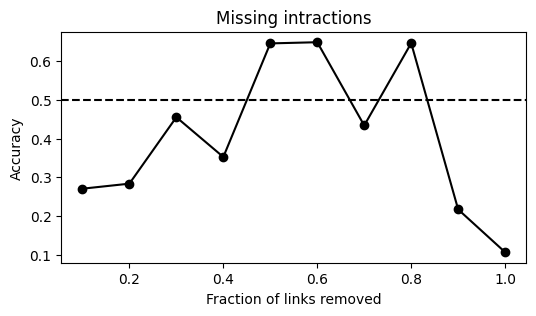

In [123]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links removed')
plt.title('Missing intractions')